# PCA Analysis on *Ostrea lurida*
This R notebook takes a *genind* R object of one SNP per GBS locus, fills in missing data, runs PCA using [*adegenet*](http://adegenet.r-forge.r-project.org/files/tutorial-basics.pdf), and then generates pretty figures using [*PCAviz*](https://github.com/NovembreLab/PCAviz). This is done for the full SNP dataset, the neutral only dataset, and the outlier only dataset, so it is repetetive.

In [11]:
library("adegenet") #for storing genetic data and running PCA
library("PCAviz")  #Visualizing output of PCA
library("cowplot") #Used with PCAviz

Loading required package: ggplot2

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



## Combined dataset

In [2]:
load("../Inputs/OL-c85t10-x45m75-maf025-u.genind")
stratted.u

/// GENIND OBJECT /////////

 // 117 individuals; 6,186 loci; 12,372 alleles; size: 9.3 Mb

 // Basic content
   @tab:  117 x 12372 matrix of allele counts
   @loc.n.all: number of alleles per locus (range: 2-2)
   @loc.fac: locus factor for the 12372 columns of @tab
   @all.names: list of allele names for each locus
   @ploidy: ploidy of each individual  (range: 2-2)
   @type:  codom
   @call: radiator::write_genind(data = input)

 // Optional content
   @pop: population of each individual (group size range: 4-9)
   @strata: a data frame with 3 columns ( POPULATION, LOCATION, REGION )
   @other: a list containing: LATITUDE  LONGITUDE 


A function to fill in missing data. At each locus, for each individual missing data at that locus, it randomly draws two alleles from the **rangewide, overall** allele frequency.

In [3]:
NA.afDraw<- function(ind){
  ind.mat <- ind@tab
  new.mat <- ind.mat
  af = colSums(ind.mat[,seq(1,ncol(ind.mat)-1,2)],na.rm = TRUE)/
      (2*apply(ind.mat[,seq(1,ncol(ind.mat)-1,2)],2,function(x) sum(!is.na(x))))
  af.Draw <- function(geno, af){
     new <- function(geno,af){
        if(is.na(geno)){
        newA = rbinom(1,2,af)
        }
        else {newA <- geno}
        return(newA)
   }
  new.row <- mapply(geno,af,FUN = new)
  return(new.row)}
  
  new.mat[,seq(1,ncol(ind.mat)-1,2)] <- t(apply(ind.mat[,seq(1,ncol(ind.mat)-1,2)],1,af.Draw,af))
  new.mat[,seq(2,ncol(ind.mat),2)] <- 2-new.mat[,seq(1,ncol(ind.mat)-1,2)]
  new.ind <- ind
  new.ind@tab <- new.mat
  return(new.ind)
}

In [4]:
u.na <- NA.afDraw(stratted.u)

PCA using adagenet. First, we view how much variation is captured by each axes.

Select the number of axes: 


You can reproduce this result non-interactively with: 
dudi.pca(df = u.na, center = TRUE, scale = TRUE, scannf = FALSE, nf = NA)



ERROR: Error in if (nf <= 0) nf <- 2: missing value where TRUE/FALSE needed


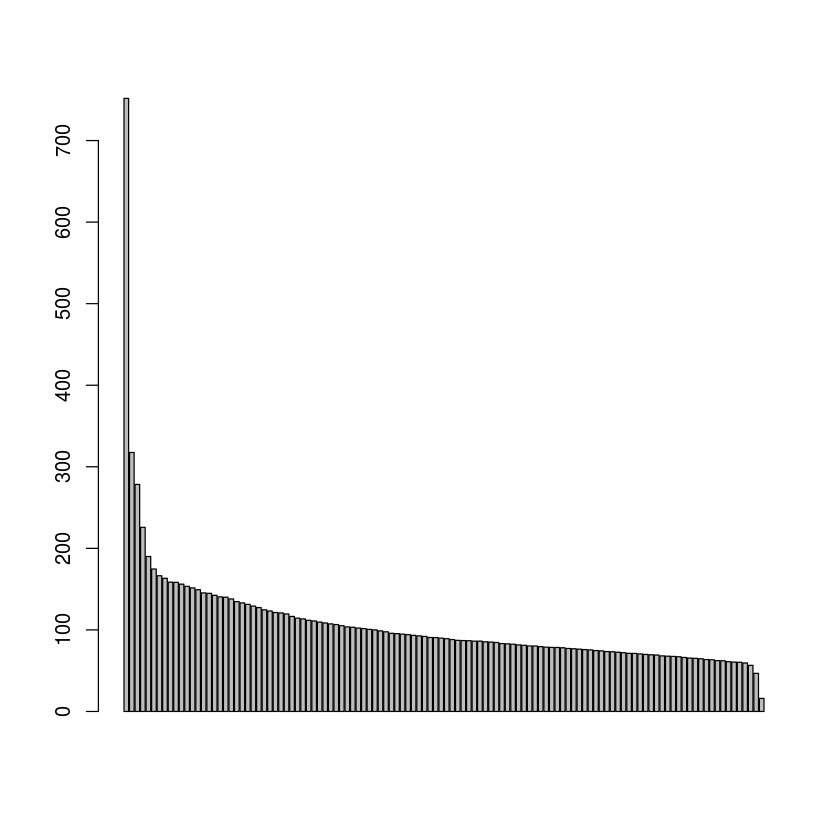

In [5]:
pca <- dudi.pca(u.na,cent=TRUE,scale=TRUE,scannf = T)

Now run PCA for real.

In [6]:
pca <- dudi.pca(u.na,cent=TRUE,scale=TRUE,scannf = F, nf = 30)

In [7]:
#the order of the regions, for choosing the order of colors
levels(strata(u.na)$REGION)

[1] "NWBC"     "Puget+BC" "Willapa"  "Oregon"   "NoCal"    "SoCal"

Plot PCs 1-5, coloring individuals by their phylogeographic region.

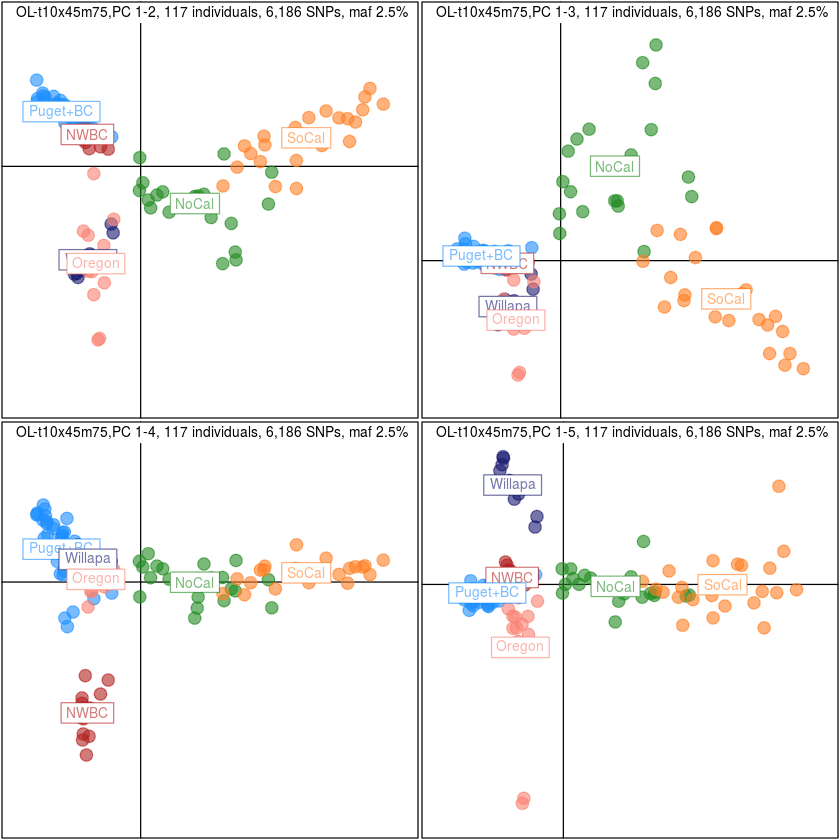

In [8]:
#col18 <- funky(length(unique(u.na@strata$POPULATION)))
#Colors that match the neutral Structure results
col6 <-  c("firebrick","dodgerblue","midnightblue","salmon","forestgreen","chocolate1")

par(mfrow=c(2,2))
s.class(pca$li, strata(u.na)$REGION,xax=1,yax=2, 
        sub = "OL-t10x45m75,PC 1-2, 117 individuals, 6,186 SNPs, maf 2.5%",
        possub = "topleft",col=transp(col6,.6),axesell=FALSE,
        cstar=0, cpoint=3, grid=FALSE, cellipse = 0)
s.class(pca$li, strata(u.na)$REGION,xax=1,yax=3, 
        sub = "OL-t10x45m75,PC 1-3, 117 individuals, 6,186 SNPs, maf 2.5%",
        possub = "topleft",col=transp(col6,.6),axesell=FALSE,
        cstar=0, cpoint=3, grid=FALSE, cellipse = 0)
s.class(pca$li, strata(u.na)$REGION,xax=1,yax=4, 
        sub = "OL-t10x45m75,PC 1-4, 117 individuals, 6,186 SNPs, maf 2.5%",
        possub = "topleft",col=transp(col6,.6),axesell=FALSE,
        cstar=0, cpoint=3, grid=FALSE, cellipse = 0)
s.class(pca$li, strata(u.na)$REGION,xax=1,yax=5, 
        sub = "OL-t10x45m75,PC 1-5, 117 individuals, 6,186 SNPs, maf 2.5%",
        possub = "topleft",col=transp(col6,.6),axesell=FALSE,
        cstar=0, cpoint=3, grid=FALSE, cellipse = 0)

I use s.label to help identify individuals that are maybe in weird places

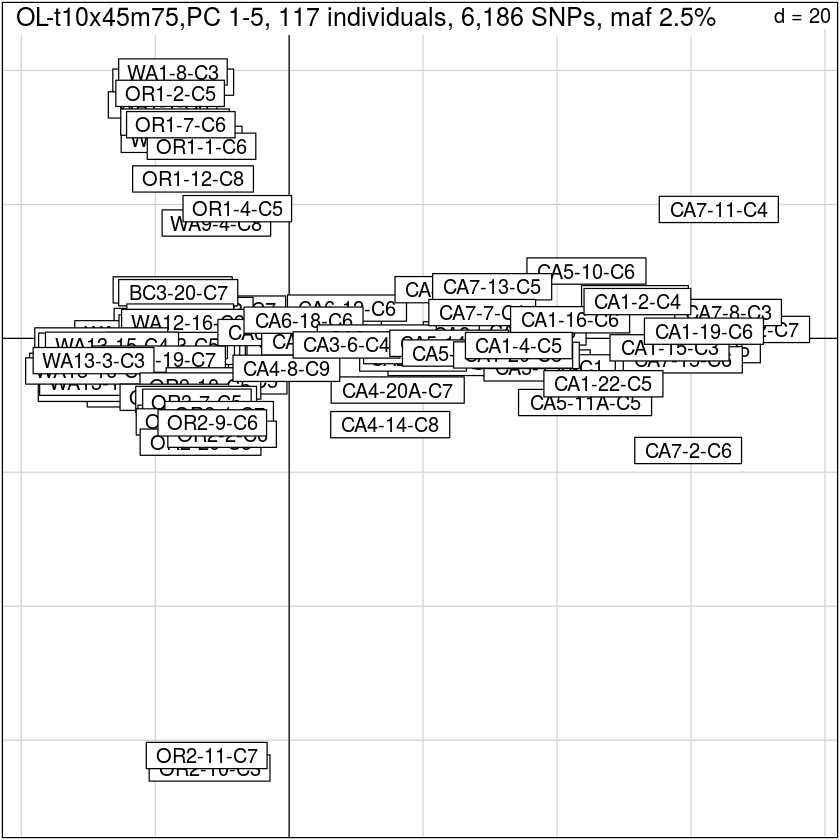

In [9]:
s.label(pca$li, xax=1,yax=5, 
        sub = "OL-t10x45m75,PC 1-5, 117 individuals, 6,186 SNPs, maf 2.5%",
        possub = "topleft")

Get percent contribution of each PC for representing variation. 

In [9]:
eig.perc <- 100*pca$eig/sum(pca$eig)
head(eig.perc)

[1] 6.075683 2.566832 2.249805 1.824848 1.535552 1.411883

### PCAviz
From John Novembre's lab [Github](https://github.com/NovembreLab/PCAviz). Allows a lot of plotting flexibility.

In [12]:
li <-pca$li
c1 <- pca$c1
#Create dataframe of info like latitude and population for each individual
info_mat <- as.data.frame(cbind(u.na$strata, u.na$other$LATITUDE,u.na$other$LONGITUDE))
colnames(info_mat) <- c("Population","Location","Region","Latitude","Longitude")
colnames(c1) <- colnames(li)
#create pcaviz object
pviz <- pcaviz(x=li,rotation=c1,dat=info_mat)

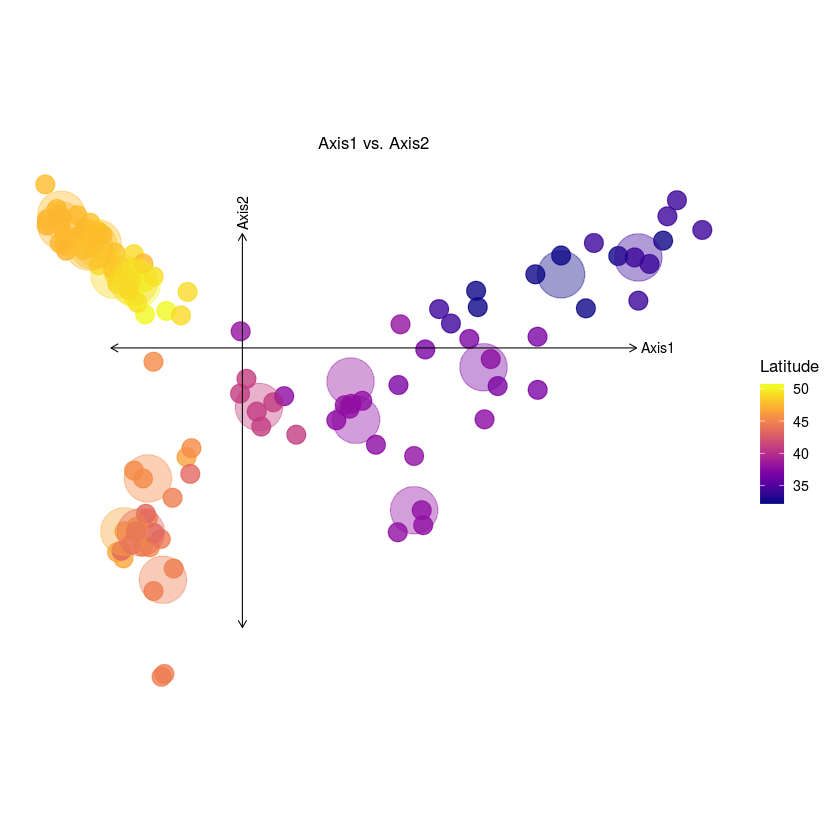

In [24]:
p = list(size=4) 
#geom.point.params = p
plot(pviz,color = "Latitude", draw.points = T, group.summary.labels = F, 
     draw.pc.axes = T, geom.point.params= list(size = 5, alpha = 0.8),
     geom.point.summary.params = list(size =13,alpha = 0.4))


Can even plot PCs vs other factors, like latitude.

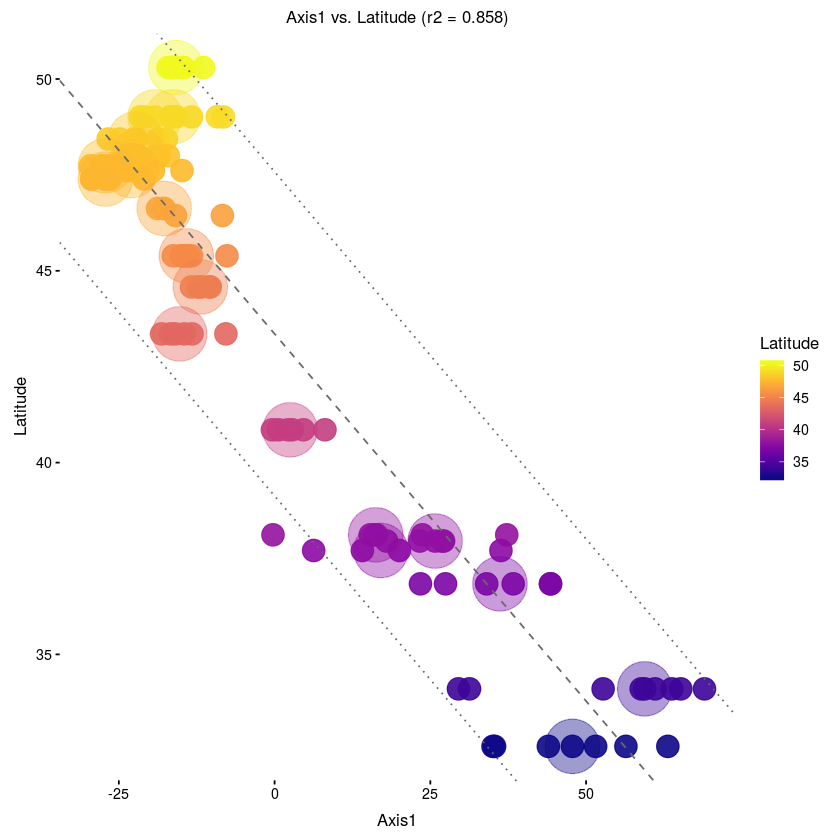

In [28]:
plot(pviz,coords = c("Axis1","Latitude"),group="Population",
     show.legend = T,color = "Latitude",
     draw.points =T,group.summary.labels = F,
    geom.point.params= list(size = 6, alpha = 0.9),
     geom.point.summary.params = list(size =15,alpha = 0.4))

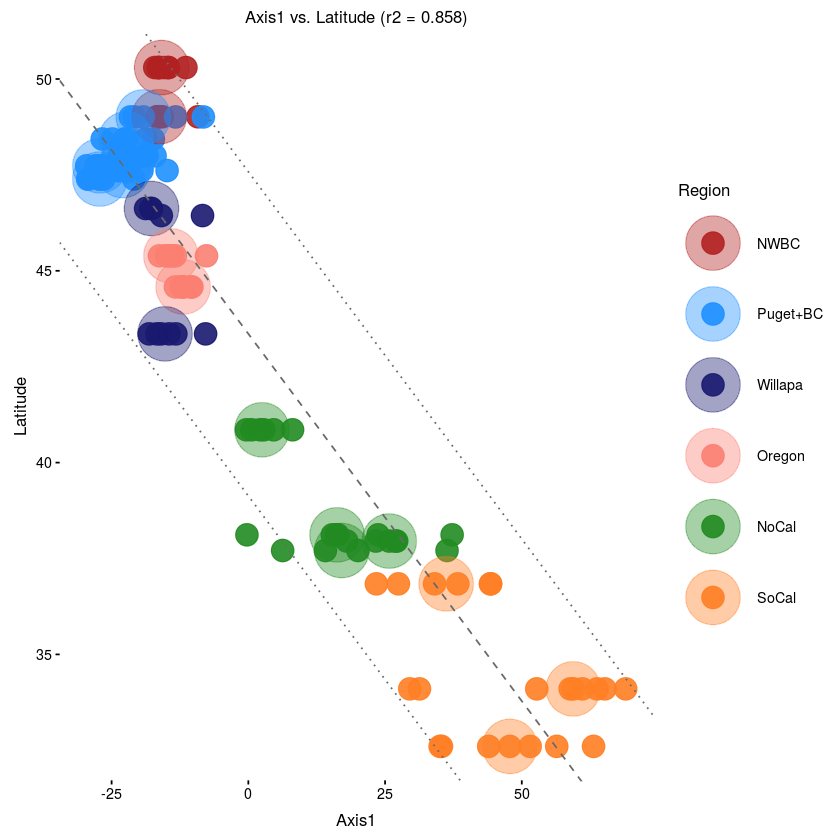

In [29]:
plot(pviz,coords = c("Axis1","Latitude"),group="Population",
     show.legend = T,color = "Region", colors = col6,
     draw.points =T,group.summary.labels = F,
    geom.point.params= list(size = 6, alpha = 0.9),
     geom.point.summary.params = list(size =15,alpha = 0.4))

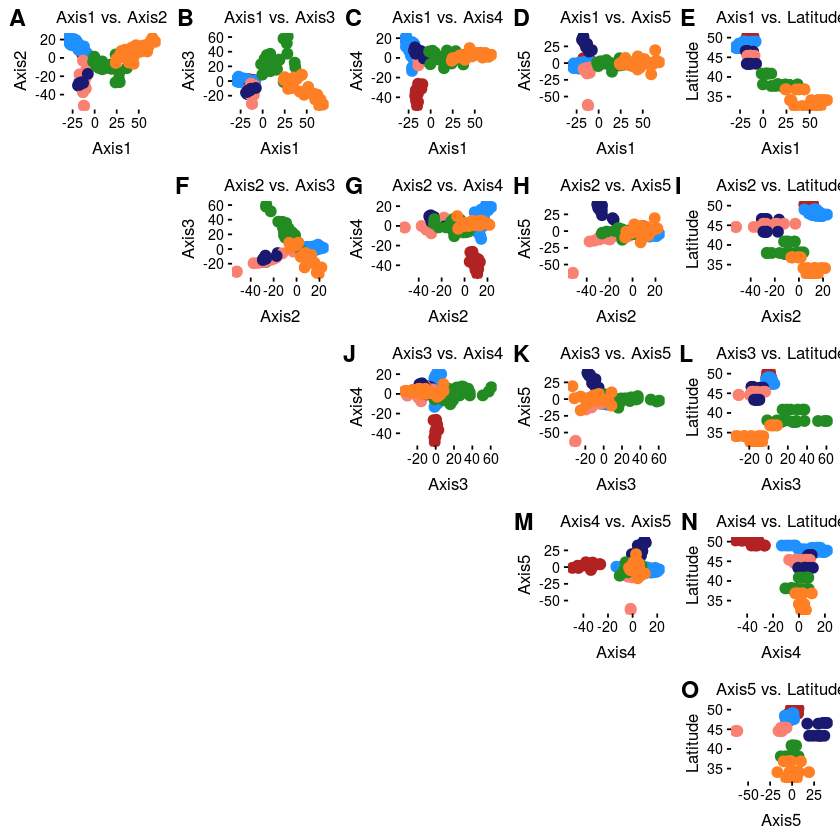

In [14]:
plot(pviz,coords = c("Axis1","Axis2","Axis3","Axis4","Axis5","Latitude"),group = NULL,color= "Region",colors = col6,draw.points = T,scale.pc.axes = 0.6, show.legend=F)

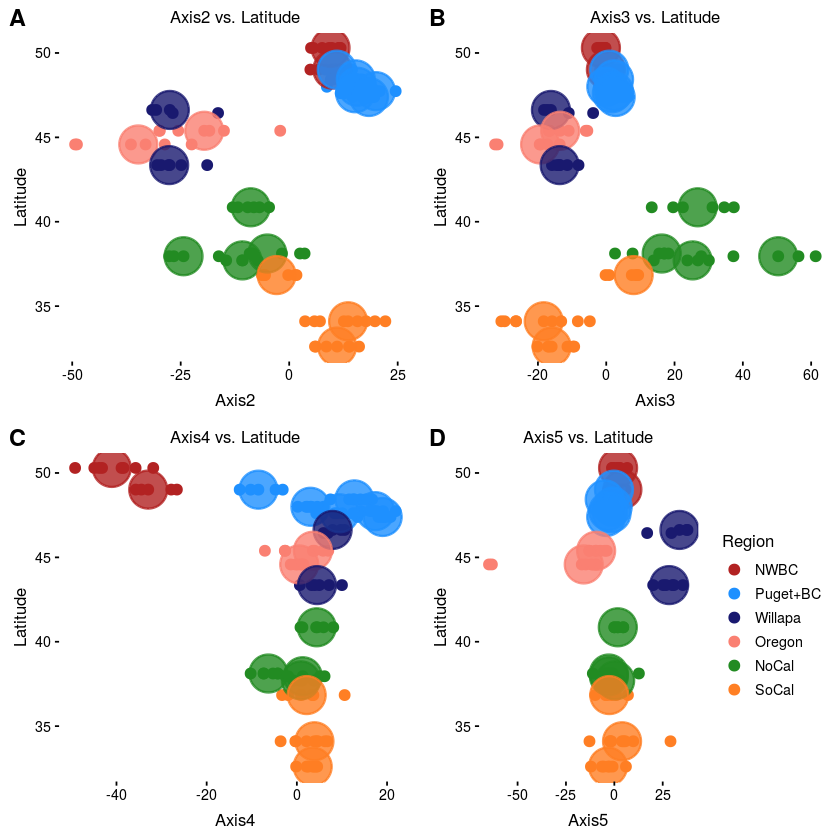

In [30]:
p = list(size=6)
A2 <- plot(pviz,coords = c("Axis2","Latitude"),group="Population",
     show.legend = F,color = "Region",colors = col6,draw.points =T,
     group.summary.labels = F,draw.linear.fit = F, coord_fixed=T)
A3 <- plot(pviz,coords = c("Axis3","Latitude"),group="Population",
     show.legend = F,color = "Region",colors = col6,
     draw.points =T,group.summary.labels = F,draw.linear.fit = F)
A4 <- plot(pviz,coords = c("Axis4","Latitude"),group="Population",
     show.legend = F,color = "Region",colors = col6,
     draw.points =T,group.summary.labels = F,draw.linear.fit = F)
A5 <- plot(pviz,coords = c("Axis5","Latitude"),group="Population",
     show.legend = T,color = "Region",colors = col6,
     draw.points =T,group.summary.labels = F,draw.linear.fit = F)
plot_grid(A2,A3,A4,A5, labels = c('A','B','C','D'))

## Neutral dataset

In [34]:
load("../Inputs/OL-c85t10-x45m75-maf025-neutI2-u.genind")
stratted.u

/// GENIND OBJECT /////////

 // 117 individuals; 6,057 loci; 12,114 alleles; size: 8.7 Mb

 // Basic content
   @tab:  117 x 12114 matrix of allele counts
   @loc.n.all: number of alleles per locus (range: 2-2)
   @loc.fac: locus factor for the 12114 columns of @tab
   @all.names: list of allele names for each locus
   @ploidy: ploidy of each individual  (range: 2-2)
   @type:  codom
   @call: radiator::write_genind(data = input)

 // Optional content
   @pop: population of each individual (group size range: 4-9)
   @strata: a data frame with 3 columns ( POPULATION, LOCATION, REGION )
   @other: a list containing: LATITUDE  LONGITUDE 


A function to fill in missing data. At each locus, for each individual missing data at that locus, it randomly draws two alleles from the **rangewide, overall** allele frequency.

In [35]:
u.na <- NA.afDraw(stratted.u)

Select the number of axes: 


You can reproduce this result non-interactively with: 
dudi.pca(df = u.na, center = TRUE, scale = TRUE, scannf = FALSE, nf = integer(0))



ERROR: Error in if (nf <= 0) nf <- 2: argument is of length zero


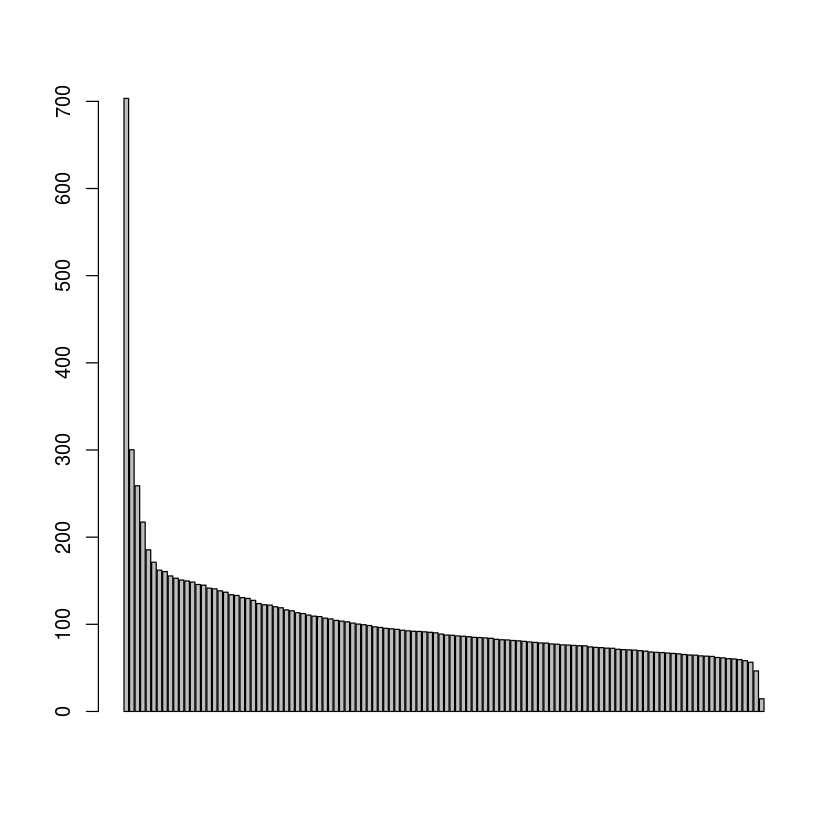

In [36]:
pca <- dudi.pca(u.na,cent=TRUE,scale=TRUE,scannf = T)

In [37]:
pca <- dudi.pca(u.na,cent=TRUE,scale=TRUE,scannf = F, nf = 30)

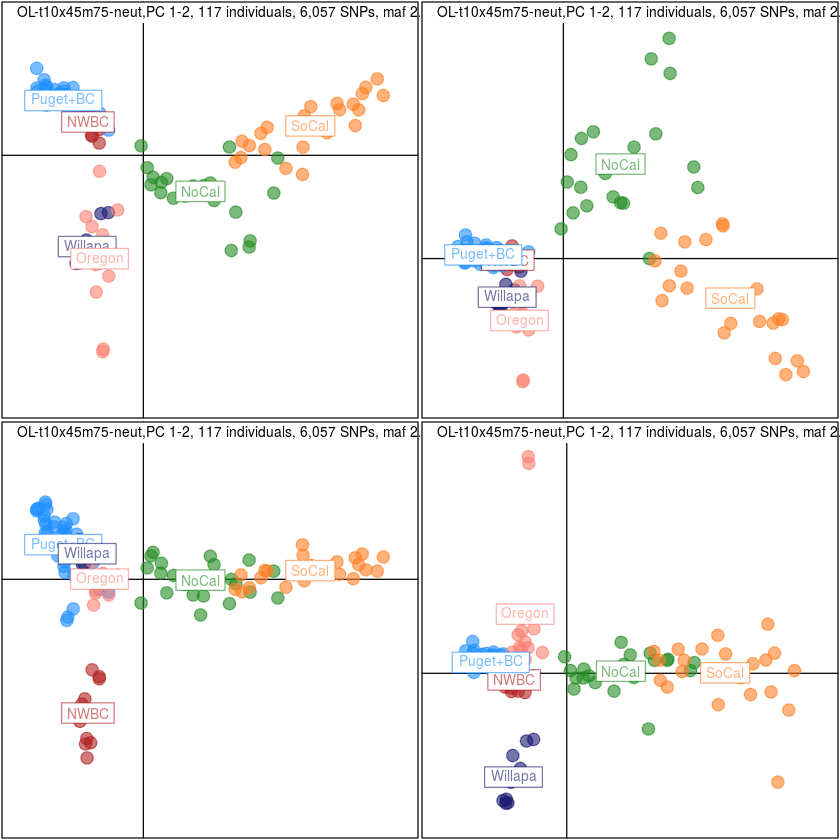

In [38]:
col18 <- funky(length(unique(u.na@strata$POPULATION)))
#Colors that match the neutral Structure results
col6 <-  c("firebrick","dodgerblue","midnightblue","salmon","forestgreen","chocolate1")

par(mfrow=c(2,2))
s.class(pca$li, strata(u.na)$REGION,xax=1,yax=2, 
        sub = "OL-t10x45m75-neut,PC 1-2, 117 individuals, 6,057 SNPs, maf 2.5%",
        possub = "topleft",col=transp(col6,.6),axesell=FALSE,
        cstar=0, cpoint=3, grid=FALSE, cellipse = 0)
s.class(pca$li, strata(u.na)$REGION,xax=1,yax=3, 
        sub = "OL-t10x45m75-neut,PC 1-2, 117 individuals, 6,057 SNPs, maf 2.5%",
        possub = "topleft",col=transp(col6,.6),axesell=FALSE,
        cstar=0, cpoint=3, grid=FALSE, cellipse = 0)
s.class(pca$li, strata(u.na)$REGION,xax=1,yax=4, 
        sub = "OL-t10x45m75-neut,PC 1-2, 117 individuals, 6,057 SNPs, maf 2.5%",
        possub = "topleft",col=transp(col6,.6),axesell=FALSE,
        cstar=0, cpoint=3, grid=FALSE, cellipse = 0)
s.class(pca$li, strata(u.na)$REGION,xax=1,yax=5, 
        sub = "OL-t10x45m75-neut,PC 1-2, 117 individuals, 6,057 SNPs, maf 2.5%",
        possub = "topleft",col=transp(col6,.6),axesell=FALSE,
        cstar=0, cpoint=3, grid=FALSE, cellipse = 0)

I use s.label to help identify individuals that are in weird places

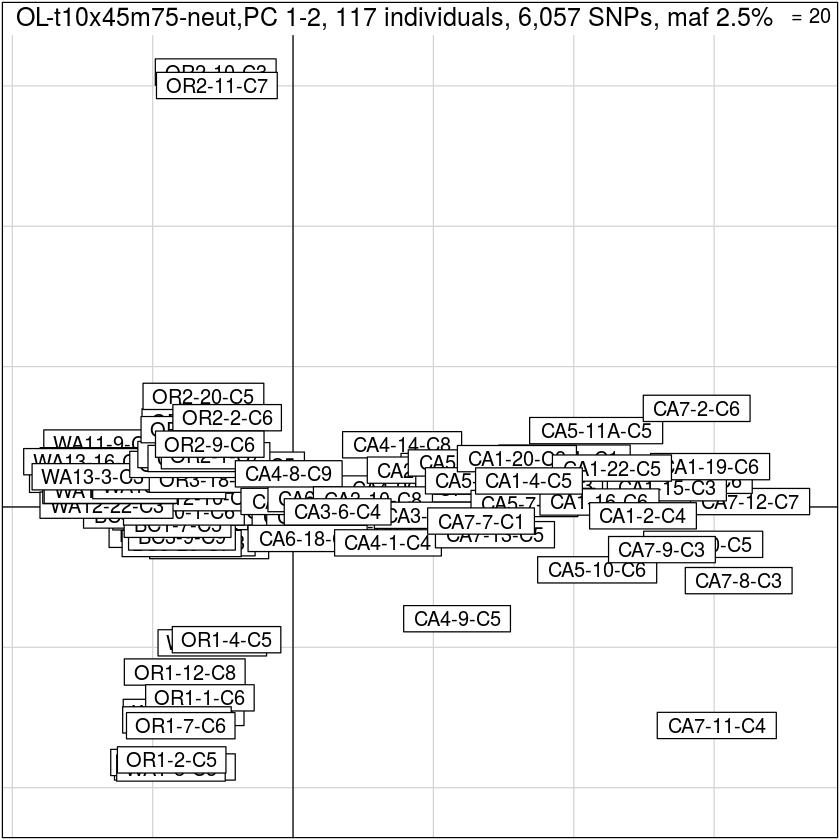

In [39]:
s.label(pca$li, xax=1,yax=5, 
        sub = "OL-t10x45m75-neut,PC 1-2, 117 individuals, 6,057 SNPs, maf 2.5%",
        possub = "topleft")

Get percent contribution of each PC 

In [40]:
eig.perc <- 100*pca$eig/sum(pca$eig)
head(eig.perc)

[1] 5.806390 2.478555 2.137471 1.793613 1.531055 1.413748

### PCAviz
From John Novembre's lab [Github](https://github.com/NovembreLab/PCAviz)

In [41]:
li <-pca$li
c1 <- pca$c1
#Create dataframe of info like latitude and population for each individual
info_mat <- as.data.frame(cbind(u.na$strata, u.na$other$LATITUDE,u.na$other$LONGITUDE))
colnames(info_mat) <- c("Population","Location","Region","Latitude","Longitude")
colnames(c1) <- colnames(li)
#create pcaviz object
pviz <- pcaviz(x=li,rotation=c1,dat=info_mat)

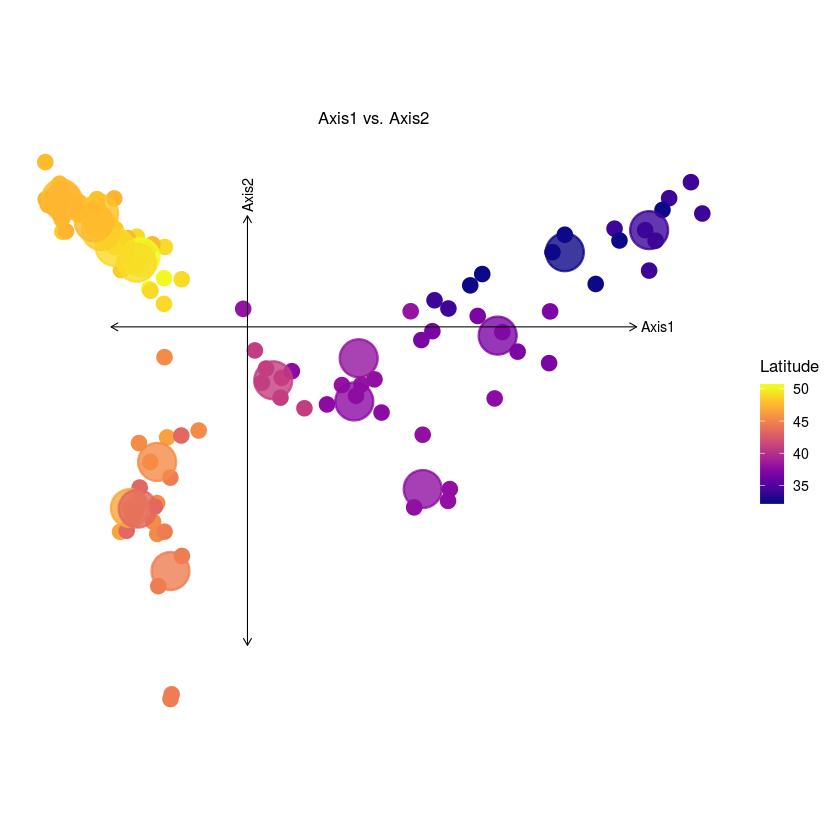

In [42]:
p = list(size=4) 
plot(pviz,color = "Latitude", draw.points = T, group.summary.labels = F, draw.pc.axes = T, geom.point.params = p)

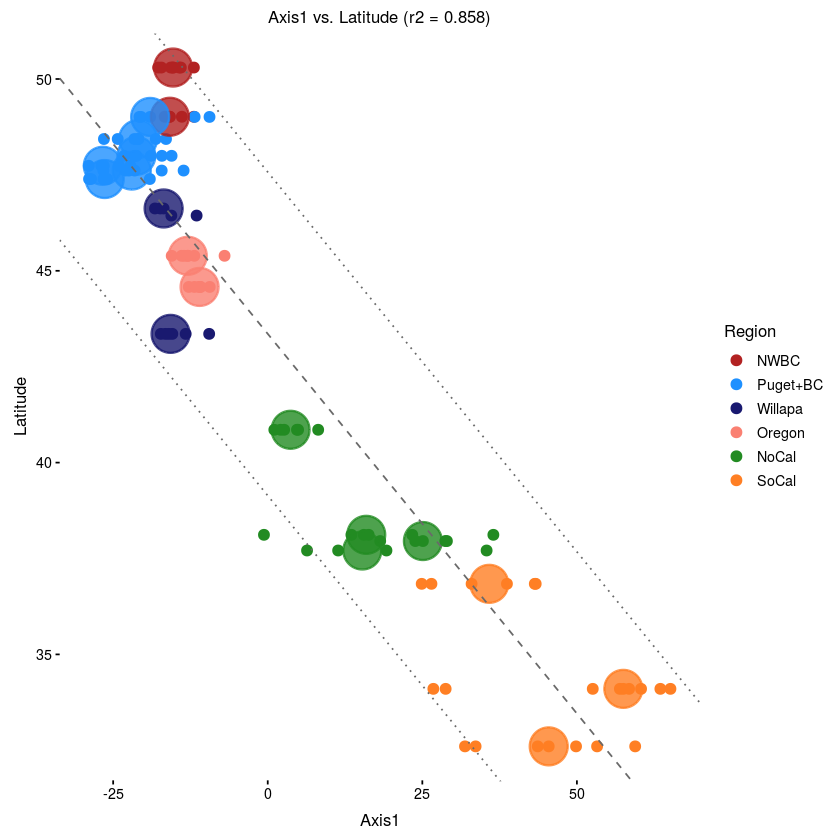

In [43]:
p = list(size=6)
plot(pviz,coords = c("Axis1","Latitude"),group="Population",
     show.legend = T,color = "Region",colors = col6,
     draw.points =T,group.summary.labels = F)

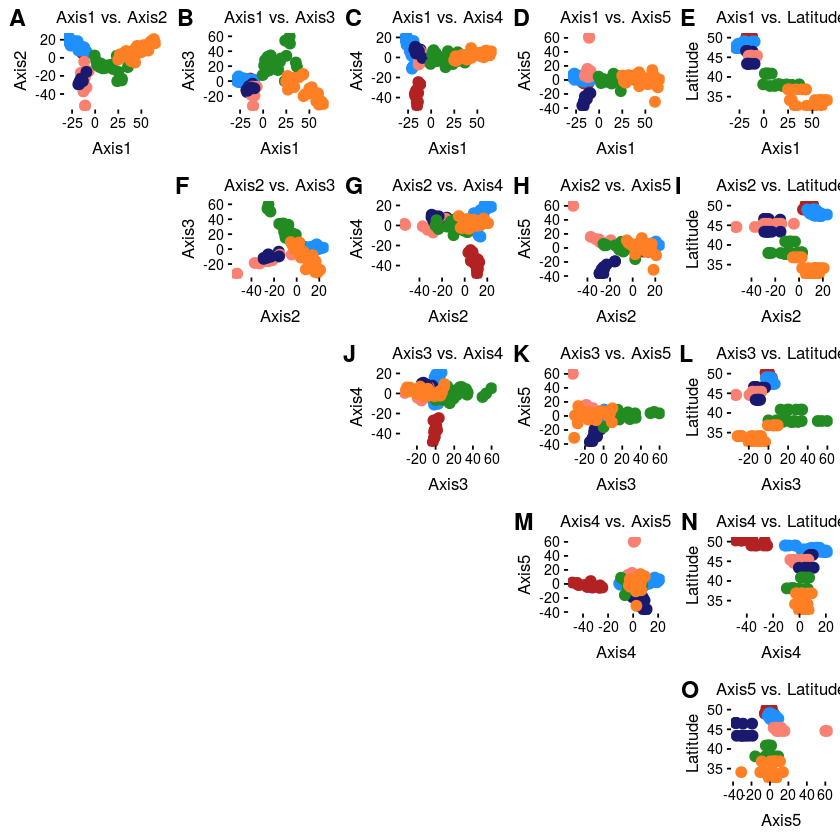

In [44]:
plot(pviz,coords = c("Axis1","Axis2","Axis3","Axis4","Axis5","Latitude"),group = NULL,color= "Region",colors = col6,draw.points = T,scale.pc.axes = 0.6, show.legend=F)

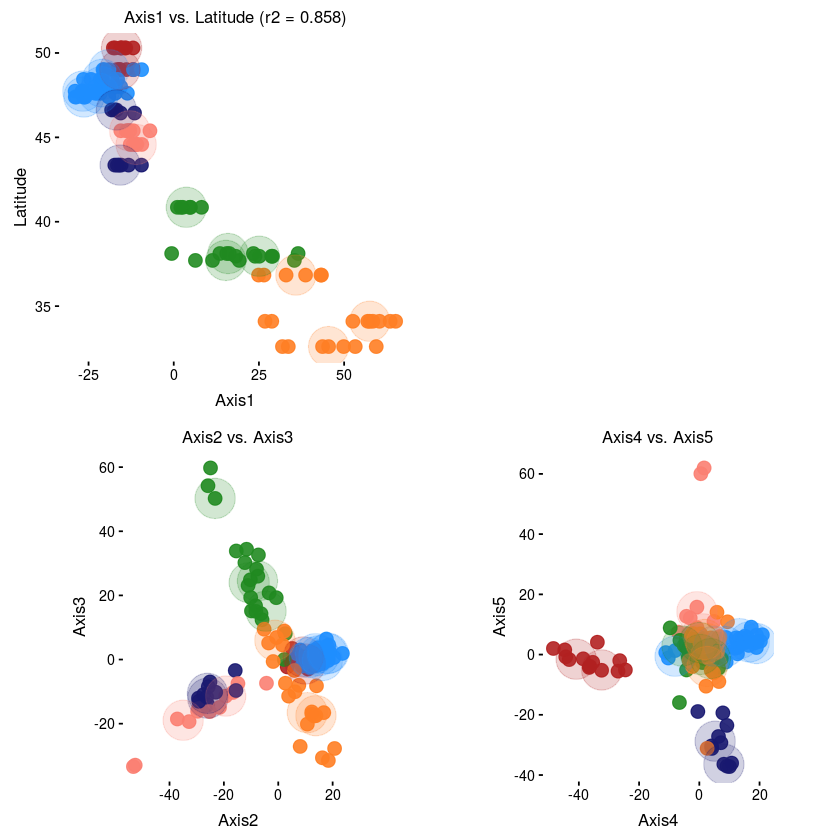

In [45]:
A2 <- plot(pviz,coords = c("Axis1","Latitude"),group="Population",show.r.squared = T,
     show.legend = F,color = "Region",colors = col6,draw.points =T,coord_fixed = T,
     group.summary.labels = F,draw.linear.fit = F, 
     geom.point.summary.params = list(size =11,alpha = 0.2), geom.point.params= list(size = 3.5, alpha = 0.9))

A3 <- plot(pviz,coords = c("Axis2","Axis3"),group="Population", 
     show.legend = F,color = "Region",colors = col6,
     draw.points =T,group.summary.labels = F,draw.linear.fit = F, 
           geom.point.summary.params = list(size =11,alpha = 0.2), geom.point.params= list(size = 3.5, alpha = 0.9))

A4 <- plot(pviz,coords = c("Axis4","Axis5"),group="Population",
     show.legend = F,color = "Region",colors = col6,
     draw.points =T,group.summary.labels = F,draw.linear.fit = F,
           geom.point.summary.params = list(size =11,alpha = 0.2),geom.point.params= list(size = 3.5, alpha = 0.9))


plot_grid(A2,NULL,A3,A4, align = 'h')

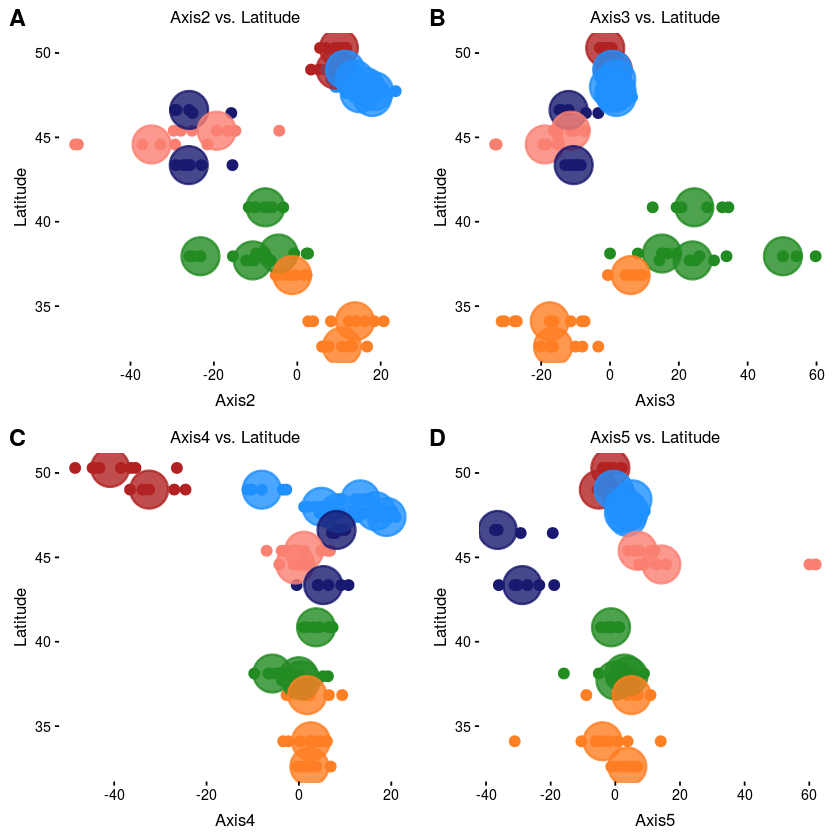

In [46]:
p = list(size=6)
A2 <- plot(pviz,coords = c("Axis2","Latitude"),group="Population",
     show.legend = F,color = "Region",colors = col6,draw.points =T,
     group.summary.labels = F,draw.linear.fit = F, coord_fixed=T)
A3 <- plot(pviz,coords = c("Axis3","Latitude"),group="Population",
     show.legend = F,color = "Region",colors = col6,
     draw.points =T,group.summary.labels = F,draw.linear.fit = F)
A4 <- plot(pviz,coords = c("Axis4","Latitude"),group="Population",
     show.legend = F,color = "Region",colors = col6,
     draw.points =T,group.summary.labels = F,draw.linear.fit = F)
A5 <- plot(pviz,coords = c("Axis5","Latitude"),group="Population",
     show.legend = F,color = "Region",colors = col6,
     draw.points =T,group.summary.labels = F,draw.linear.fit = F)
plot_grid(A2,A3,A4,A5, labels = c('A','B','C','D'))

## Outlier dataset

In [47]:
load("../Inputs/OL-c85t10-x45m75-maf025-outI2Union-u.genind")
stratted.u

/// GENIND OBJECT /////////

 // 117 individuals; 129 loci; 258 alleles; size: 212.1 Kb

 // Basic content
   @tab:  117 x 258 matrix of allele counts
   @loc.n.all: number of alleles per locus (range: 2-2)
   @loc.fac: locus factor for the 258 columns of @tab
   @all.names: list of allele names for each locus
   @ploidy: ploidy of each individual  (range: 2-2)
   @type:  codom
   @call: radiator::write_genind(data = input)

 // Optional content
   @pop: population of each individual (group size range: 4-9)
   @strata: a data frame with 3 columns ( POPULATION, LOCATION, REGION )
   @other: a list containing: LATITUDE  LONGITUDE 


A function to fill in missing data. At each locus, for each individual missing data at that locus, it randomly draws two alleles from the **rangewide, overall** allele frequency.

In [48]:
out.na <- NA.afDraw(stratted.u)

Select the number of axes: 


You can reproduce this result non-interactively with: 
dudi.pca(df = out.na, center = TRUE, scale = TRUE, scannf = FALSE, nf = integer(0))



ERROR: Error in if (nf <= 0) nf <- 2: argument is of length zero


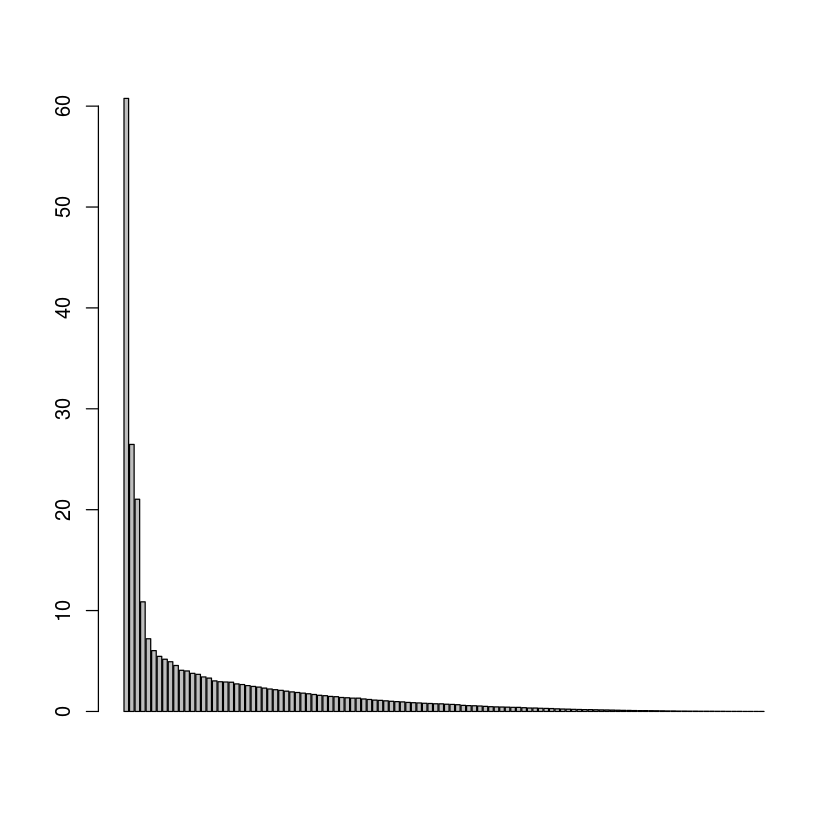

In [49]:
pca <- dudi.pca(out.na,cent=TRUE,scale=TRUE,scannf = T)

In [50]:
pca.out <- dudi.pca(out.na,cent=TRUE,scale=TRUE,scannf = F, nf = 30)

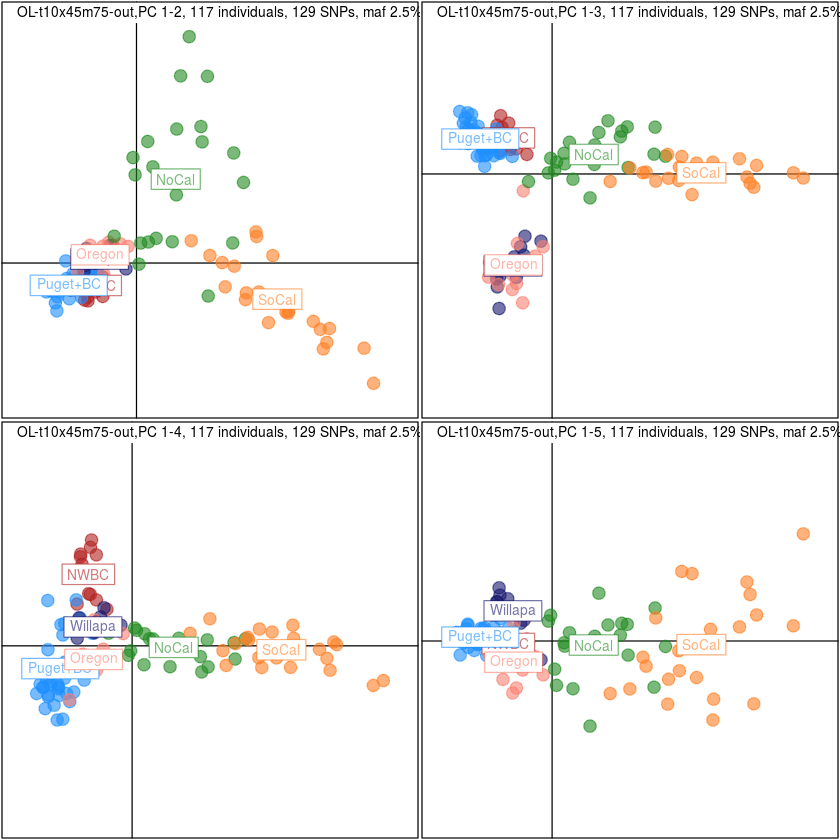

In [51]:
col18 <- funky(length(unique(out.na@strata$POPULATION)))
#Colors that match the neutral Structure results
col6 <-  c("firebrick","dodgerblue","midnightblue","salmon","forestgreen","chocolate1")

par(mfrow=c(2,2))
s.class(pca.out$li, strata(out.na)$REGION,xax=1,yax=2, 
        sub = "OL-t10x45m75-out,PC 1-2, 117 individuals, 129 SNPs, maf 2.5%",
        possub = "topleft",col=transp(col6,.6),axesell=FALSE,
        cstar=0, cpoint=3, grid=FALSE, cellipse = 0)
s.class(pca.out$li, strata(out.na)$REGION,xax=1,yax=3, 
        sub = "OL-t10x45m75-out,PC 1-3, 117 individuals, 129 SNPs, maf 2.5%",
        possub = "topleft",col=transp(col6,.6),axesell=FALSE,
        cstar=0, cpoint=3, grid=FALSE, cellipse = 0)
s.class(pca.out$li, strata(out.na)$REGION,xax=1,yax=4, 
        sub = "OL-t10x45m75-out,PC 1-4, 117 individuals, 129 SNPs, maf 2.5%",
        possub = "topleft",col=transp(col6,.6),axesell=FALSE,
        cstar=0, cpoint=3, grid=FALSE, cellipse = 0)
s.class(pca.out$li, strata(out.na)$REGION,xax=1,yax=5, 
        sub = "OL-t10x45m75-out,PC 1-5, 117 individuals, 129 SNPs, maf 2.5%",
        possub = "topleft",col=transp(col6,.6),axesell=FALSE,
        cstar=0, cpoint=3, grid=FALSE, cellipse = 0)

I use s.label to help identify individuals that are in weird places

Get percent contribution of each PC 

In [52]:
eig.perc <- 100*pca.out$eig/sum(pca.out$eig)
head(eig.perc)

[1] 23.552974 10.259385  8.152902  4.211792  2.793492  2.336478

### PCAviz
From John Novembre's lab [Github](https://github.com/NovembreLab/PCAviz)

In [53]:
li <-pca.out$li
c1 <- pca.out$c1
#Create dataframe of info like latitude and population for each individual
info_mat <- as.data.frame(cbind(out.na$strata, out.na$other$LATITUDE,out.na$other$LONGITUDE))
colnames(info_mat) <- c("Population","Location","Region","Latitude","Longitude")
colnames(c1) <- colnames(li)
#create pcaviz object
pviz.out <- pcaviz(x=li,rotation=c1,dat=info_mat)

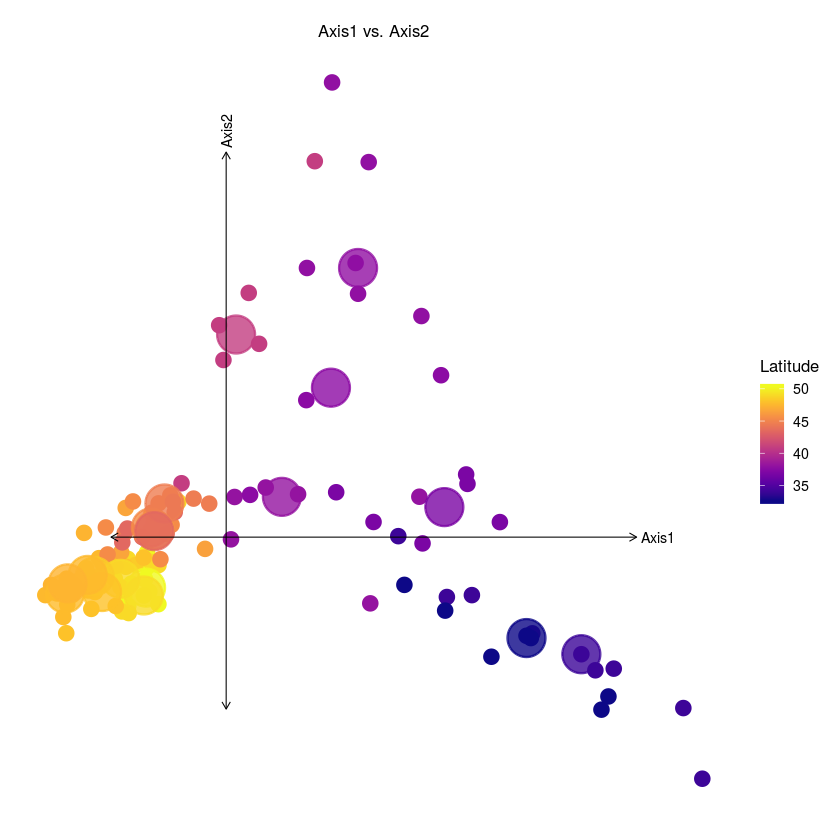

In [54]:
p = list(size=4) 
plot(pviz.out,color = "Latitude", draw.points = T, group.summary.labels = F, draw.pc.axes = T, geom.point.params = p)

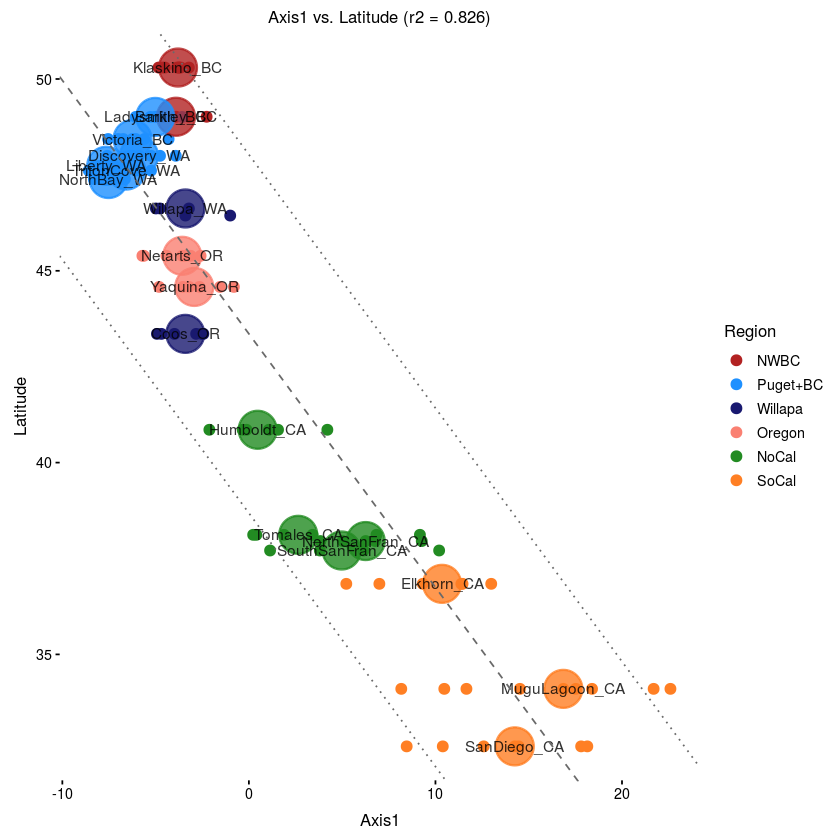

In [55]:
p = list(size=6)
plot(pviz.out,coords = c("Axis1","Latitude"),group="Population",
     show.legend = T,color = "Region",colors = col6,
     draw.points =T,group.summary.labels = T)

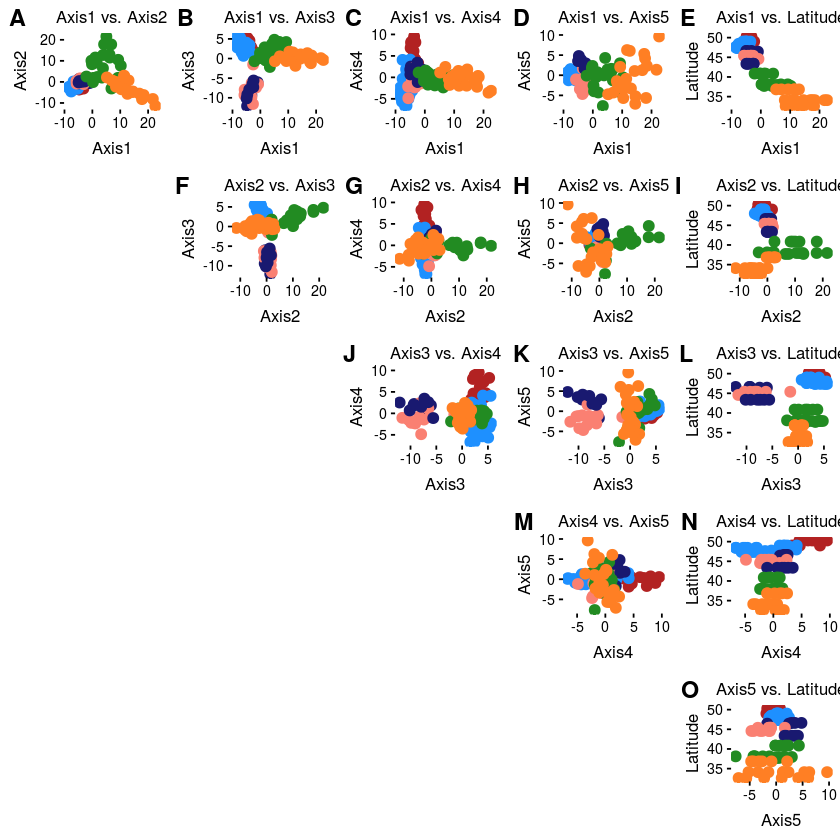

In [56]:
plot(pviz.out,coords = c("Axis1","Axis2","Axis3","Axis4","Axis5","Latitude"),group = NULL,color= "Region",colors = col6,draw.points = T,scale.pc.axes = 0.6, show.legend=F)

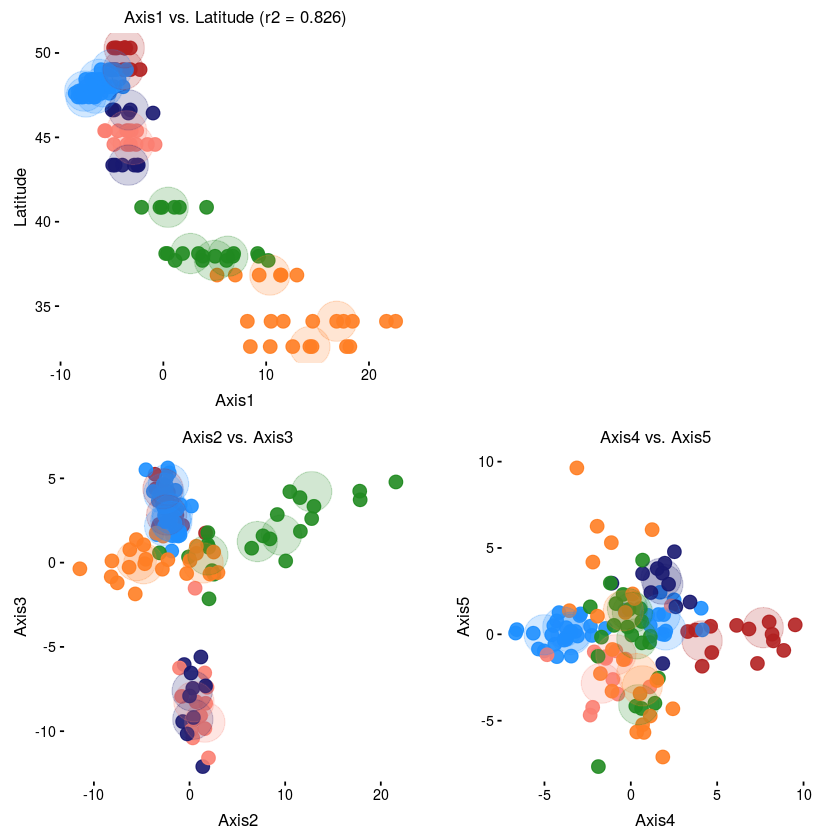

In [57]:
A2 <- plot(pviz.out,coords = c("Axis1","Latitude"),group="Population",show.r.squared = T,
     show.legend = F,color = "Region",colors = col6,draw.points =T,coord_fixed = T,
     group.summary.labels = F,draw.linear.fit = F, 
     geom.point.summary.params = list(size =11,alpha = 0.2), geom.point.params= list(size = 3.5, alpha = 0.9))

A3 <- plot(pviz.out,coords = c("Axis2","Axis3"),group="Population", 
     show.legend = F,color = "Region",colors = col6,
     draw.points =T,group.summary.labels = F,draw.linear.fit = F, 
           geom.point.summary.params = list(size =11,alpha = 0.2), geom.point.params= list(size = 3.5, alpha = 0.9))

A4 <- plot(pviz.out,coords = c("Axis4","Axis5"),group="Population",
     show.legend = F,color = "Region",colors = col6,
     draw.points =T,group.summary.labels = F,draw.linear.fit = F,
           geom.point.summary.params = list(size =11,alpha = 0.2),geom.point.params= list(size = 3.5, alpha = 0.9))


plot_grid(A2,NULL,A3,A4, align = 'h')

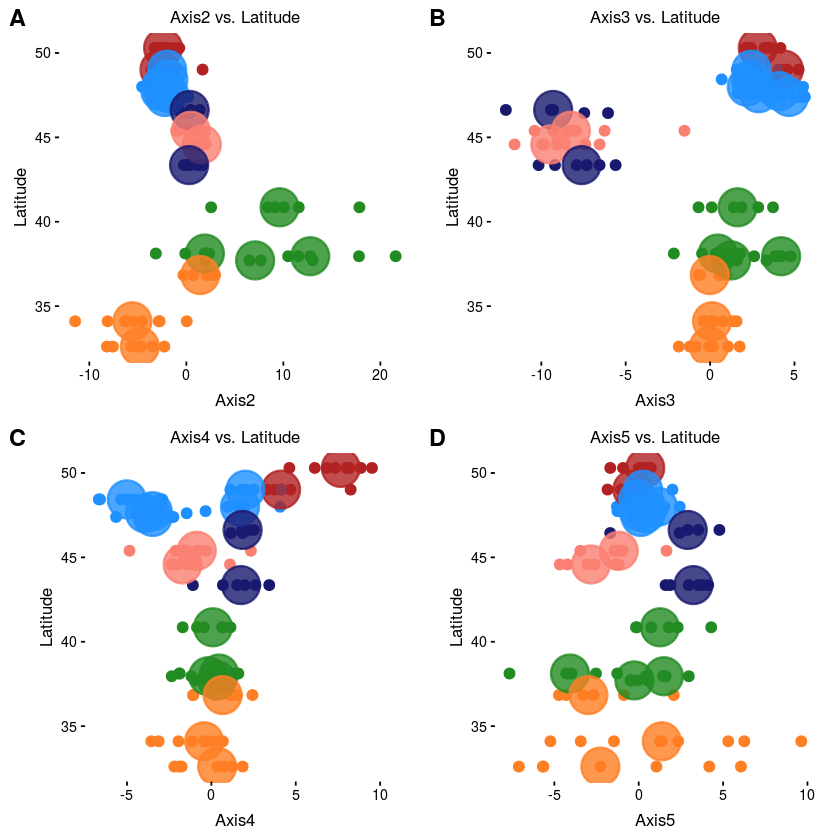

In [58]:
p = list(size=6)
A2 <- plot(pviz.out,coords = c("Axis2","Latitude"),group="Population",
     show.legend = F,color = "Region",colors = col6,draw.points =T,
     group.summary.labels = F,draw.linear.fit = F, coord_fixed=T)
A3 <- plot(pviz.out,coords = c("Axis3","Latitude"),group="Population",
     show.legend = F,color = "Region",colors = col6,
     draw.points =T,group.summary.labels = F,draw.linear.fit = F)
A4 <- plot(pviz.out,coords = c("Axis4","Latitude"),group="Population",
     show.legend = F,color = "Region",colors = col6,
     draw.points =T,group.summary.labels = F,draw.linear.fit = F)
A5 <- plot(pviz.out,coords = c("Axis5","Latitude"),group="Population",
     show.legend = F,color = "Region",colors = col6,
     draw.points =T,group.summary.labels = F,draw.linear.fit = F)
plot_grid(A2,A3,A4,A5, labels = c('A','B','C','D'))